In [1]:
##import the necessary packages.

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import time

#set the random seed to obtain outcomes.
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
#Extract the MINIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

#change into black and white
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255




In [3]:
#Seperate the different data
#discard the label data because of unsupervised learning
digit1_train=X_train[y_train==1]
digit2_train=X_train[y_train==2]
digit3_train=X_train[y_train==3]
digit4_train=X_train[y_train==4]
digit5_train=X_train[y_train==5]
digit6_train=X_train[y_train==6]
digit7_train=X_train[y_train==7]
digit8_train=X_train[y_train==8]
digit9_train=X_train[y_train==9]
digit0_train=X_train[y_train==0]


digit1_test=X_test[y_test==1]
digit2_test=X_test[y_test==2]
digit3_test=X_test[y_test==3]
digit4_test=X_test[y_test==4]
digit5_test=X_test[y_test==5]
digit6_test=X_test[y_test==6]
digit7_test=X_test[y_test==7]
digit8_test=X_test[y_test==8]
digit9_test=X_test[y_test==9]
digit0_test=X_test[y_test==0]

In [4]:
#combind digit 3 and digit 6 as a whole dataset
digit_train=np.append(digit3_train,digit6_train,axis=0)
digit_test=np.append(digit3_test,digit6_test,axis=0)

In [5]:
#Define the function
#The function shifts images in a horizontal way to right.

def Shift_h(shift,inputs):
    #shift horizontally function 
    rows,cols=inputs.shape[1:3]
    data_train=[]
    for k in range(inputs.shape[0]):
        for i in range(0,shift):
            #fit the data into new position according to equation
            zeros=np.zeros((rows,cols+shift))
            zeros[:rows,i:i+cols]=inputs[k]
            data_train.append(zeros)
    data_train=np.asarray(data_train)
    return data_train

In [6]:
data_train=Shift_h(12,digit_train)
data_test=Shift_h(12,digit_test)

In [7]:
def plot_image(image):
    plt.imshow(image, cmap="gray")#), interpolation="nearest")
    plt.axis("off")

In [484]:
digit3_train.shape[0] * 12

73572

In [486]:
x_train=data_train[list(range(60000))+list(range(73572,133572)),:]
x_valid=data_train[list(range(60000,73572))+list(range(133572,144588)),:]

In [487]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))# threhold matters.

In [488]:
K = keras.backend
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [489]:
#define a function to show reconstructions according to the diversity of latent space dimensionality.
#here we only focus on the dimension of latent variable 


#Here we pre-defined the VAE layers so that the shape need to be manually adjusted
def VAE(codings_size_val):
    tf.random.set_seed(42)
    np.random.seed(42)
    ###latent space dimension
    codings_size = codings_size_val
    #Encoder
    inputs = keras.layers.Input(shape=[28, 40])          #pixels according to the inputs
    z = keras.layers.Flatten()(inputs)                   #Flatten the features
    z = keras.layers.Dense(150, activation="selu")(z)    #fully connected Layer 1
    z = keras.layers.Dense(100, activation="selu")(z)    #fully connected Layer 2
    codings_mean = keras.layers.Dense(codings_size)(z)   #Latent space
    codings_log_var = keras.layers.Dense(codings_size)(z)#Sampling Gaussian distribution
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.models.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
    ###########################################################################
    #Decoder
    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(100, activation="selu")(decoder_inputs)     #fully connected Layer 1
    x = keras.layers.Dense(150, activation="selu")(x)                  #fully connected Layer 2
    x = keras.layers.Dense(28 * 40, activation="sigmoid")(x)           #Output Layer
    outputs = keras.layers.Reshape([28, 40])(x)
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs]) #combined encoder and decoder
    ###########################################################################
    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings) #how to structure reconstructions
    variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
    ###########################################################################
    #regularization term
    latent_loss = -0.5 * K.sum(
        1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
        axis=-1)
    variational_ae.add_loss(K.mean(latent_loss) / 1120.) 
    variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop",metrics=[rounded_accuracy])
    #return the model
    return variational_ae

In [519]:
def show_reconstructions(model, images=x_valid, n_images=12):
    counts=images.shape[0]/12
    #randomly selected version
    #randoms=np.random.randint(0,counts,n_images)
    #index=12 * randoms
    
    #show the motion of digit 3 and 6
    ids=[0,13572]
    index=list(range(ids[0],ids[0]+12,2))+list(range(ids[1],ids[1]+12,2))
    reconstructions = model.predict(images[index])
    fig = plt.figure(figsize=(n_images * 3, 5))
    
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.title('Original image')
        plot_image(images[index[image_index]])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        plt.title('Reconstructed image')




## How we decide the suitable dimensionality of latent space

In [520]:
Performance_dim=[2,3,5,10]
#define a function to show reconstructions 
def performance(Performance_dim):
    Performance_loss=[]
    Performance_time=[]
    for i in Performance_dim:
        
        variational_ae=VAE(i)
        import time
        time_start=time.time()
        history = variational_ae.fit(x_train, x_train, epochs=10,
                             validation_data=(x_valid, x_valid),verbose=0)
        time_end=time.time()
        time=time_end-time_start
        Performance_time.append(time)
        Performance_loss.append(history.history['loss'][-1])
        show_reconstructions(variational_ae)
        plt.savefig('digit2_dim'+str(i)+'.jpg')
    return Performance_time,Performance_loss

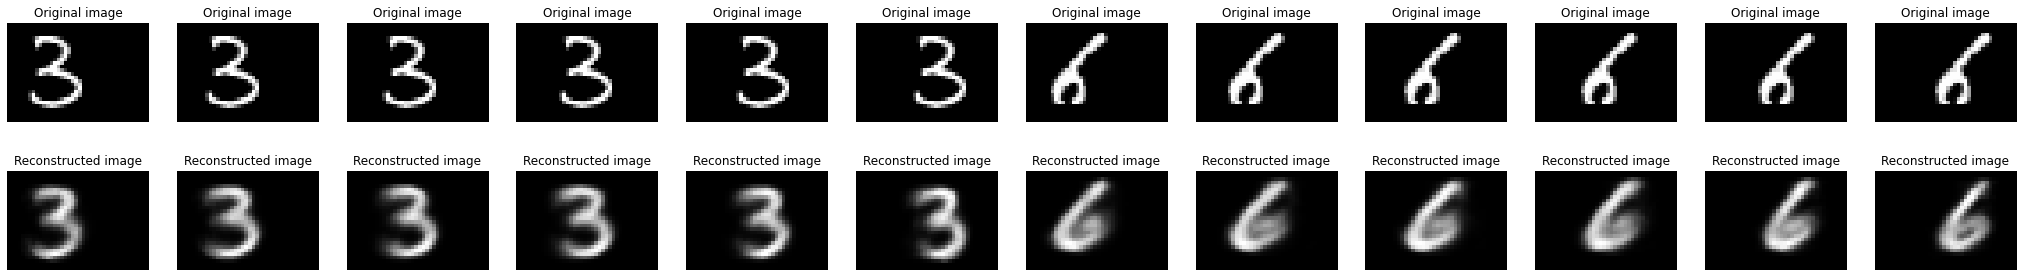

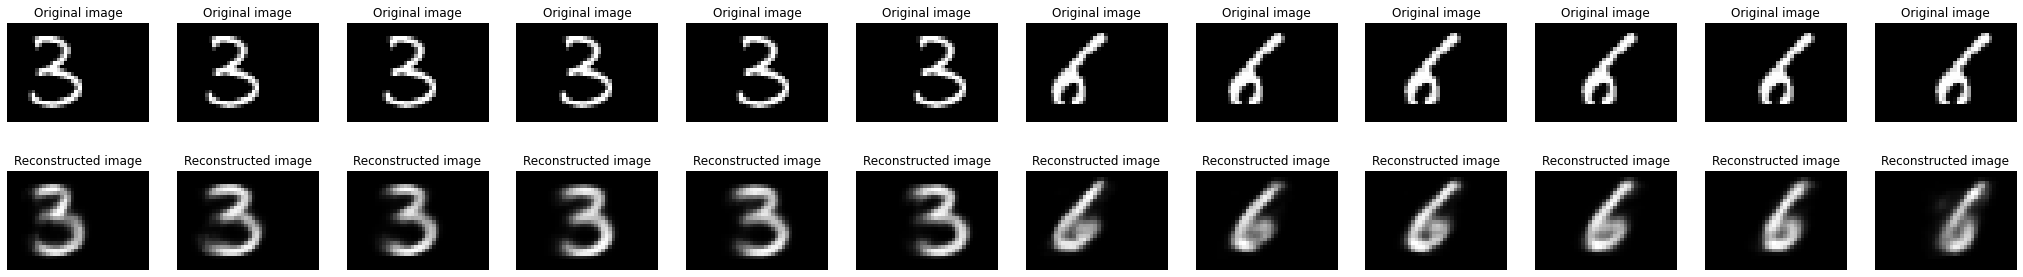

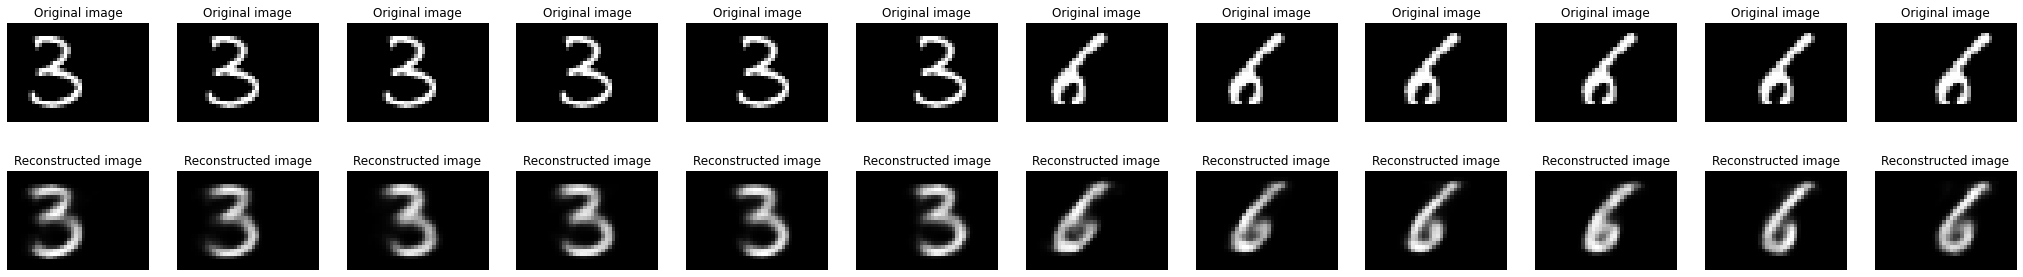

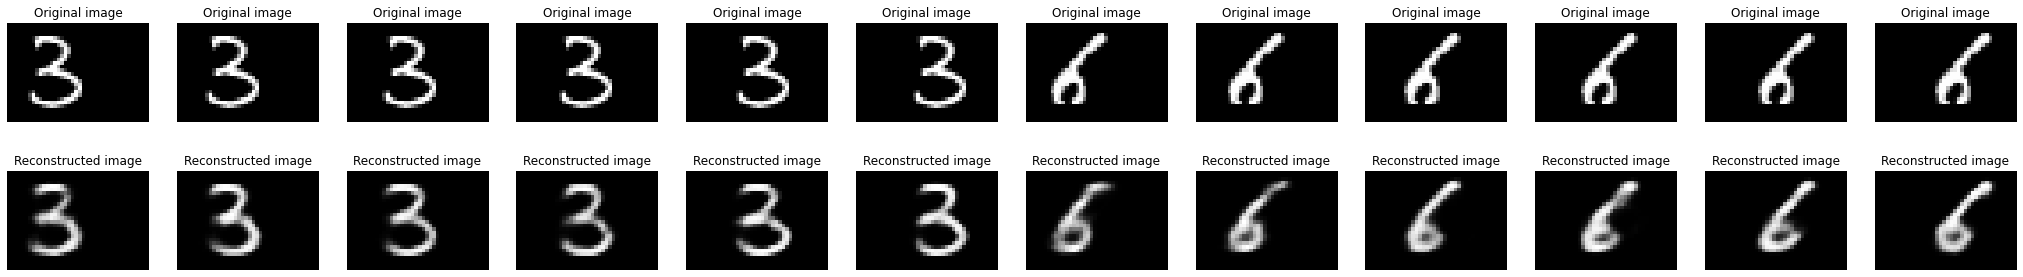

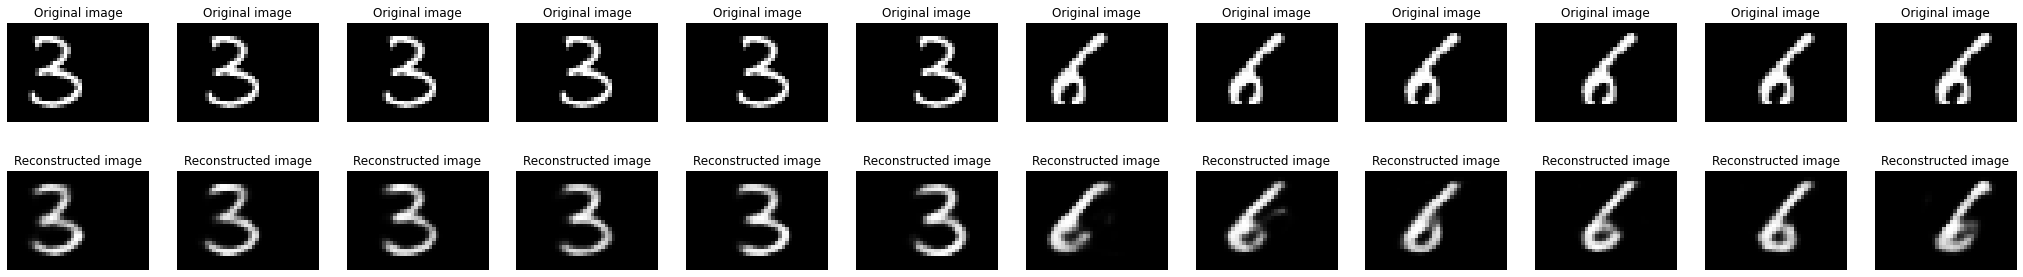

In [521]:
Performance_time,Performance_loss=performance(Performance_dim)

In [522]:
performance = pd.DataFrame({'Dimension': Performance_dim,'loss': Performance_loss, 'time':Performance_time})
performance

,Dimension,loss,time
0,2,0.143751,138.124006
1,3,0.132451,170.873764
2,5,0.119425,157.440547
3,10,0.105761,147.857716
4,20,0.103340,144.395867


## How to identify the underlying meaning of latent variables in chosen latent space? 

In [523]:
tf.random.set_seed(42)
np.random.seed(42)
#############################################
#according to the previous outcome 
#the latent space dimensionality determined
codings_size = 5

inputs = keras.layers.Input(shape=[28, 40])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
###########################################################################
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 40, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 40])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
###########################################################################
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
###########################################################################
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 1120.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop",metrics=[rounded_accuracy])


history = variational_ae.fit(x_train, x_train, epochs=10,
                             validation_data=(x_valid, x_valid),verbose=0)
latent=variational_encoder(x_valid)[2].numpy()

In [638]:
#summary the statistics of latent variables
df=pd.DataFrame(latent)
summarys=df.describe()
summarys

,0,1,2,3,4
count,24588.000000,24588.000000,24588.000000,24588.000000,24588.000000
mean,-0.080173,0.001078,0.150778,0.129556,-0.167823
std,1.075216,1.374225,1.238248,1.295074,1.097389
min,-3.994039,-4.102240,-4.548872,-3.425799,-4.560476
25%,-0.795414,-1.020735,-0.641759,-0.996198,-0.860832
50%,-0.053962,-0.041514,0.305410,0.370017,-0.132237
75%,0.661451,1.062179,1.071298,1.170774,0.595240
max,3.616143,3.652394,3.300243,3.756653,3.504697


In [673]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(10, 10))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.title('Index '+str(index+1))
        plt.axis("off")

In [674]:
#The adjusted latent variables of quantitive method to reveal the underlying meaning of latent variables.
#here is adjusted value version for digit 3
latent_adjusted=np.zeros((12,5))
latent_adjusted1=np.zeros((12,5))
latent_adjusted2=np.zeros((12,5))
latent_adjusted3=np.zeros((12,5))
latent_adjusted4=np.zeros((12,5))


latent_adjusted[:,0]=latent[:12,0]
latent_adjusted1[:,1]=latent[:12,1]
latent_adjusted2[:,2]=latent[:12,2]
latent_adjusted3[:,3]=latent[:12,3]
latent_adjusted4[:,4]=latent[:12,4]

for i in range(12):
    latent_adjusted[i,1:5]=latent[0,1:5]
    latent_adjusted1[i,[0,2,3,4]]=latent[0,[0,2,3,4]]
    latent_adjusted2[i,[0,1,3,4]]=latent[0,[0,2,3,4]]
    latent_adjusted3[i,[0,2,1,4]]=latent[0,[0,2,1,4]]
    latent_adjusted4[i,0:4]=latent[0,0:4]

latent_adjusted.sort(axis=0)
latent_adjusted1.sort(axis=0)
latent_adjusted2.sort(axis=0)
latent_adjusted3.sort(axis=0)
latent_adjusted4.sort(axis=0)

In [675]:
latent_adjusted[0][0]=-2.5
latent_adjusted[1][0]=-2.
latent_adjusted[2][0]=-1.5
latent_adjusted[3][0]=-1.0

latent_adjusted[4][0]=-0.50999588
latent_adjusted[5][0]=-0.0688452
latent_adjusted[6][0]=0.53107476
latent_adjusted[7][0]=1.1

latent_adjusted[8][0]=1.4
latent_adjusted[9][0]=1.65
latent_adjusted[10][0]=1.9
latent_adjusted[11][0]=2.5

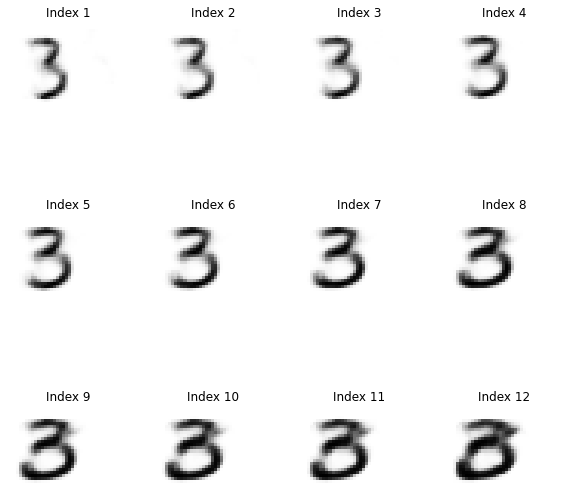

In [676]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjusted)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent0_3.jpg')

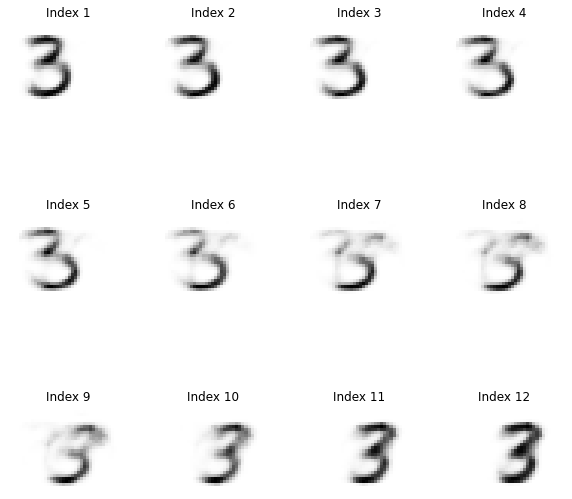

In [677]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjusted1)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent1_3.jpg')

In [643]:
latent_adjusted2[0][2]=-2.5
latent_adjusted2[1][2]=-2
latent_adjusted2[2][2]=-1.5
latent_adjusted2[3][2]=-0.91629404
latent_adjusted2[4][2]=-0.58875746


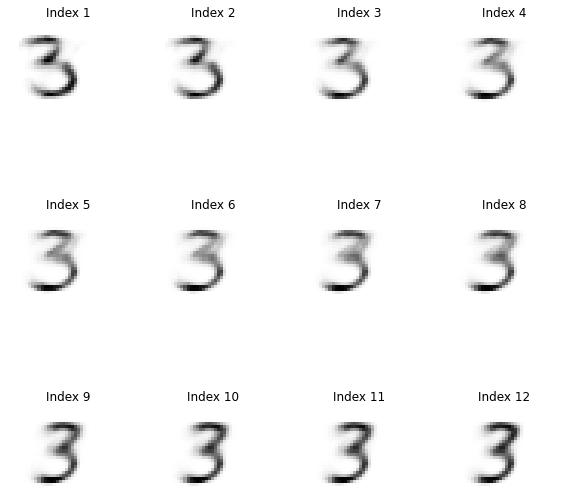

In [678]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjusted2)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent2_3.jpg')

In [645]:
latent_adjusted3[0][3]=-3
latent_adjusted3[1][3]=-2
latent_adjusted3[2][3]=-1.57832861
latent_adjusted3[3][3]=-0.58038825

latent_adjusted3[4][3]=0.0
latent_adjusted3[5][3]=0.4465107
latent_adjusted3[6][3]=0.65419567
latent_adjusted3[7][3]=0.82498056

 
latent_adjusted3[8][3]=1.15
latent_adjusted3[9][3]=1.24808776
latent_adjusted3[10][3]=1.53401124
latent_adjusted3[11][3]=2

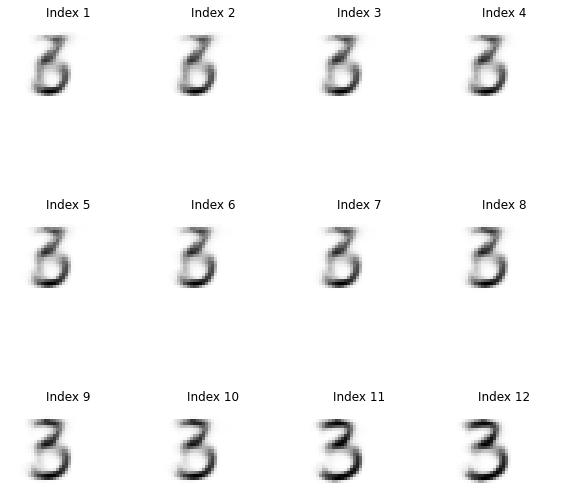

In [679]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjusted3)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent3_3.jpg')

In [681]:
latent_adjusted4[0][4]=-3
latent_adjusted4[1][4]=-2
latent_adjusted4[2][4]=-1.5
latent_adjusted4[3][4]=-1.1

latent_adjusted4[4][4]=-0.8
latent_adjusted4[5][4]=-0.32253528
latent_adjusted4[6][4]=-0.07894967
latent_adjusted4[7][4]=0.25250474

latent_adjusted4[8][4]=0.71269363
latent_adjusted4[9][4]=1.15
latent_adjusted4[10][4]=1.6
latent_adjusted4[11][4]=3

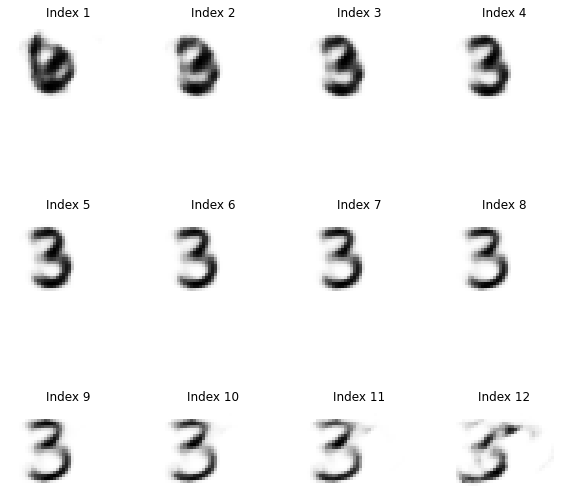

In [682]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjusted4)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent4_3.jpg')

In [650]:
#here is adjusted value version for digit 6
latent_copy=np.zeros((12,5))
latent_copy1=np.zeros((12,5))
latent_copy2=np.zeros((12,5))
latent_copy3=np.zeros((12,5))
latent_copy4=np.zeros((12,5))


latent_copy[:,0]=latent[24000:24012,0]
latent_copy1[:,1]=latent[24000:24012,1]
latent_copy2[:,2]=latent[24000:24012,2]
latent_copy3[:,3]=latent[24000:24012,3]
latent_copy4[:,4]=latent[24000:24012,4]

for i in range(12):
    latent_copy[i,1:5]=latent[24000,1:5]
    latent_copy1[i,[0,2,3,4]]=latent[24000,[0,2,3,4]]
    latent_copy2[i,[0,1,3,4]]=latent[24000,[0,2,3,4]]
    latent_copy3[i,[0,2,1,4]]=latent[24000,[0,2,1,4]]
    latent_copy4[i,0:4]=latent[24000,0:4]

latent_copy.sort(axis=0)
latent_copy1.sort(axis=0)
latent_copy2.sort(axis=0)
latent_copy3.sort(axis=0)
latent_copy4.sort(axis=0)

In [651]:
latent_copy[0][0]=-2.5
latent_copy[1][0]=-2.1
latent_copy[2][0]=-1.4406364
latent_copy[3][0]=-1.09655952

latent_copy[4][0]=-0.5856179
latent_copy[5][0]=-0.02812712
latent_copy[6][0]=0.49670526
latent_copy[7][0]=1.14879203

latent_copy[8][0]=1.4
latent_copy[9][0]=1.6
latent_copy[10][0]=2.1
latent_copy[11][0]=2.7

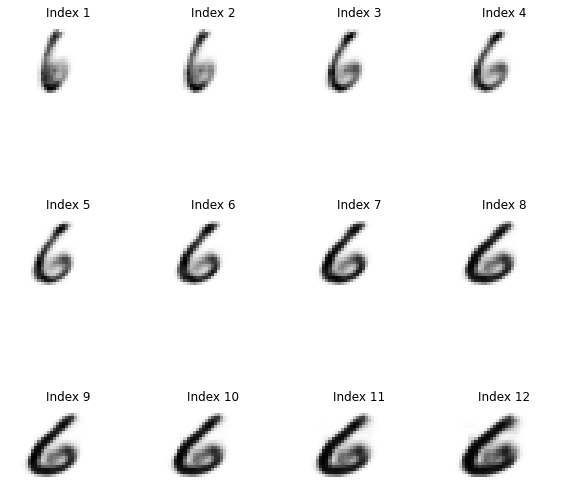

In [683]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent0_6.jpg')

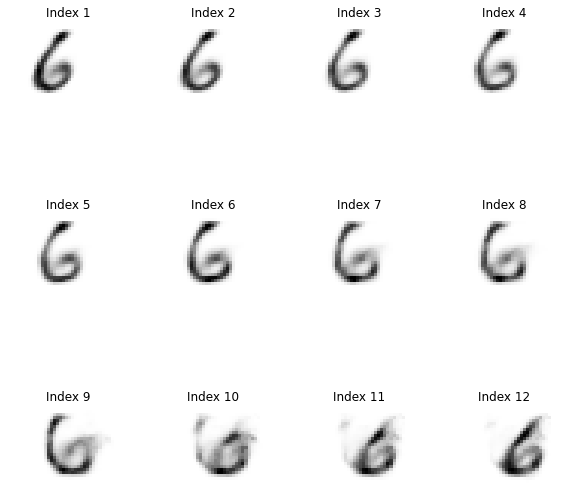

In [684]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy1)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent1_6.jpg')

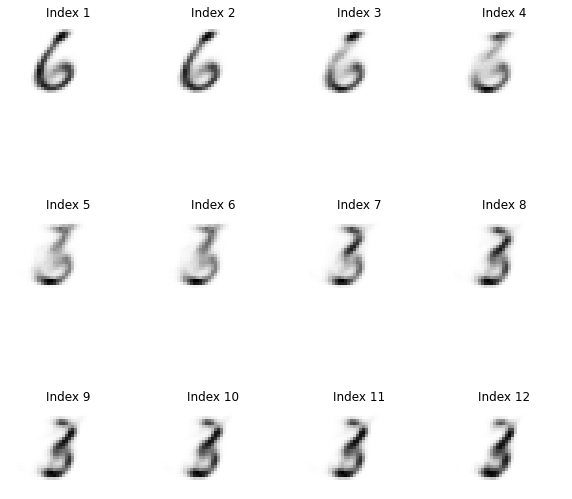

In [685]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy2)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent2_6.jpg')

In [687]:
latent_copy3[0][3]=-3
latent_copy3[1][3]=-2
latent_copy3[2][3]=-1.49180269
latent_copy3[3][3]=-0.68203819

latent_copy3[4][3]=0.02128967
latent_copy3[5][3]=0.29070002
latent_copy3[6][3]=0.56754452
latent_copy3[7][3]=0.87592363

 
latent_copy3[8][3]=1.1
latent_copy3[9][3]=1.3
latent_copy3[10][3]=1.5
latent_copy3[11][3]=2

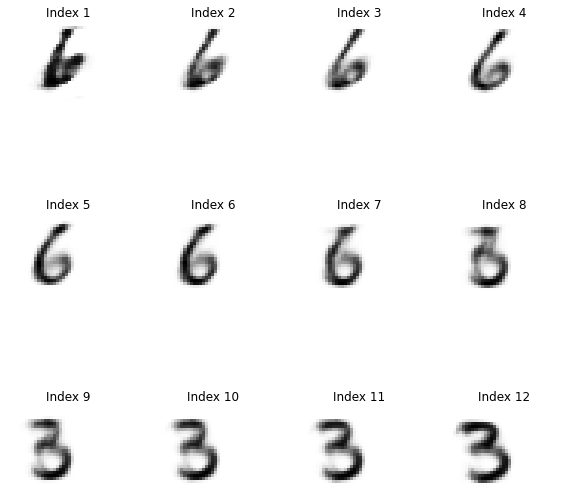

In [688]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy3)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent3_6.jpg')

In [689]:
latent_copy4[0][4]=-2.5
latent_copy4[1][4]=-2
latent_copy4[2][4]=-1.5
latent_copy4[3][4]=-1.1372155

latent_copy4[4][4]=-0.81206143
latent_copy4[5][4]=-0.38771993
latent_copy4[6][4]=-0.04275677
latent_copy4[7][4]=0.39243379

latent_copy4[8][4]=0.7834481
latent_copy4[9][4]=1.15463507
latent_copy4[10][4]=1.6
latent_copy4[11][4]=2.2

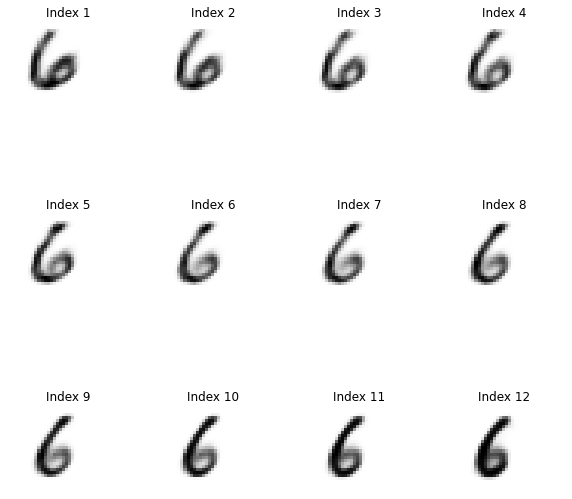

In [690]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy4)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('2digit_latent4_6.jpg')

In [661]:
#more examples here
new_latent_3_copy=np.zeros((12,5))
new_latent_3_copy1=np.zeros((12,5))
new_latent_3_copy2=np.zeros((12,5))
new_latent_3_copy3=np.zeros((12,5))
new_latent_3_copy4=np.zeros((12,5))


new_latent_3_copy[:,0]=latent[1212:1224,0]
new_latent_3_copy1[:,1]=latent[1212:1224,1]
new_latent_3_copy2[:,2]=latent[1212:1224,2]
new_latent_3_copy3[:,3]=latent[1212:1224,3]
new_latent_3_copy4[:,4]=latent[1212:1224,4]

for i in range(12):
    new_latent_3_copy[i,1:5]=latent[1212,1:5]
    new_latent_3_copy1[i,[0,2,3,4]]=latent[1212,[0,2,3,4]]
    new_latent_3_copy2[i,[0,1,3,4]]=latent[1212,[0,2,3,4]]
    new_latent_3_copy3[i,[0,2,1,4]]=latent[1212,[0,2,1,4]]
    new_latent_3_copy4[i,0:4]=latent[1212,0:4]

new_latent_3_copy.sort(axis=0)
new_latent_3_copy1.sort(axis=0)
new_latent_3_copy2.sort(axis=0)
new_latent_3_copy3.sort(axis=0)
new_latent_3_copy4.sort(axis=0)

In [662]:
new_latent_3_copy

array([[-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-1.37190211, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.90872115, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.90685266, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.86114132, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.85926795, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.80766618, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.8064298 , -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.78050888, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.72945446, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.69293636, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-0.62336838, -2.67863131, -0.45096719,  0.36593783, -0.79913759]])

In [663]:
new_latent_3_copy[0][0]=-2.57298064
new_latent_3_copy[1][0]=-2.15665007
new_latent_3_copy[2][0]=-1.57298064
new_latent_3_copy[3][0]=-1.00979424

new_latent_3_copy[4][0]=-0.5
new_latent_3_copy[5][0]=-0.
new_latent_3_copy[6][0]=0.5
new_latent_3_copy[7][0]=1.14879203

new_latent_3_copy[8][0]=1.45231164
new_latent_3_copy[9][0]=1.64795423
new_latent_3_copy[10][0]=1.92180884
new_latent_3_copy[11][0]=2.55156159

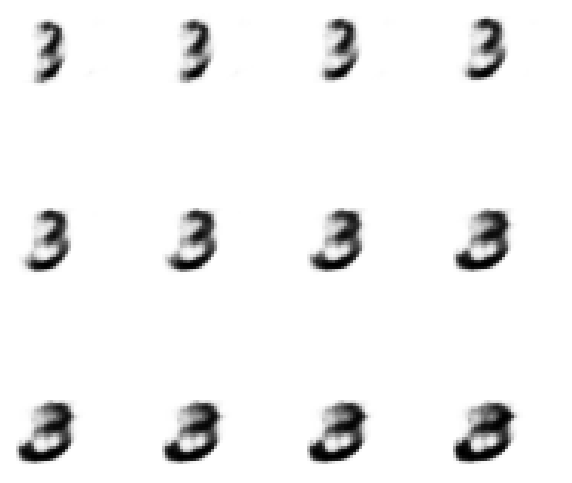

In [664]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(new_latent_3_copy)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

In [665]:
new_latent_3_copy1

array([[-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677, -2.16200304, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677, -1.82880402, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677, -1.46564877, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677, -1.16386139, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677, -0.82015991, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677, -0.44432926, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677,  0.0841243 , -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677,  0.65142882, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677,  1.1196146 , -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677,  1.60065889, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677,  1.92800784, -0.45096719,  0.36593783, -0.79913759]])

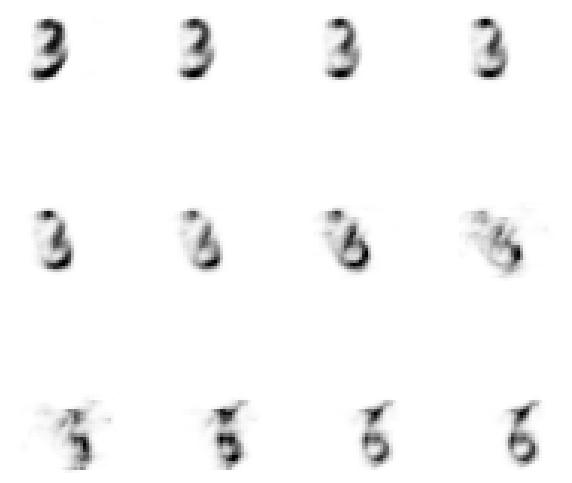

In [666]:

tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(new_latent_3_copy1)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

In [667]:
new_latent_3_copy2[0][2]=-2
new_latent_3_copy2[1][2]=-1.5
new_latent_3_copy2[2][2]=-1
new_latent_3_copy2[3][2]=-.5

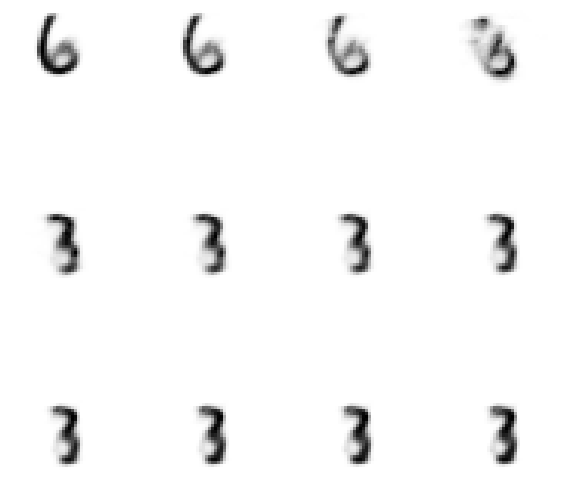

In [668]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(new_latent_3_copy2)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

In [669]:


new_latent_3_copy3[0][3]=-3
new_latent_3_copy3[1][3]=-2
new_latent_3_copy3[2][3]=-1.57832861
new_latent_3_copy3[3][3]=-0.68203819

new_latent_3_copy3[4][3]=0.02128967
new_latent_3_copy3[5][3]=0.33
new_latent_3_copy3[6][3]=0.64722192
new_latent_3_copy3[7][3]=1


new_latent_3_copy3[8][3]=1.15
new_latent_3_copy3[9][3]=1.33091879
new_latent_3_copy3[10][3]=1.53401124
new_latent_3_copy3[11][3]=2

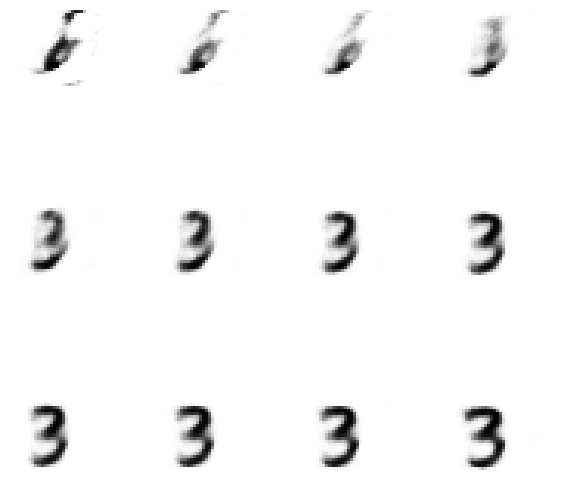

In [670]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(new_latent_3_copy3)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

In [671]:
new_latent_3_copy4

array([[-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.89703304],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.82397652],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.79913759],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.68714726],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.50636917],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.34759432],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783, -0.20633152],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783,  0.21870348],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783,  0.67898148],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783,  0.71034384],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783,  0.84495902],
       [-1.53395677, -2.67863131, -0.45096719,  0.36593783,  0.88885647]])

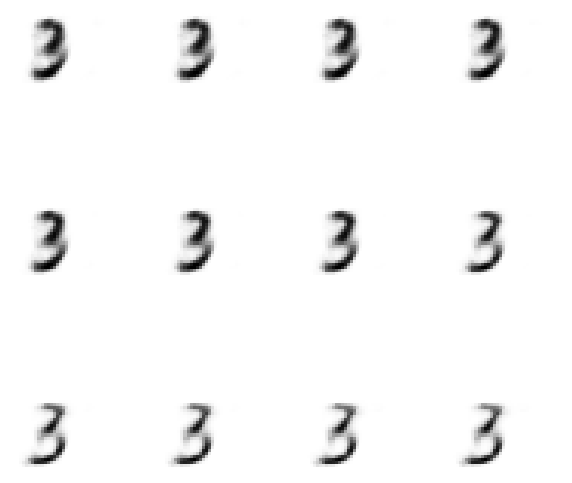

In [672]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(new_latent_3_copy4)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

## Futher Study: Whether we can apply T-SNE to achieve meaningful representation and visualization ?

In [691]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(latent)

In [692]:
digit3_randoms=np.random.randint(0,1130,6)
digit6_randoms=np.random.randint(1131,2048,6)

In [693]:
randoms=np.append(digit3_randoms,digit6_randoms,axis=0)

In [694]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

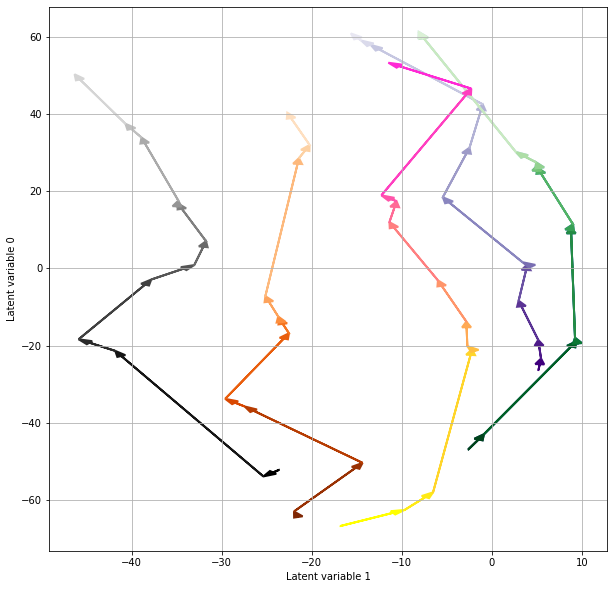

In [695]:
cmap_list=['Blues_r','Purples_r','Greens_r','Oranges_r','spring_r','gray']
plt.figure(figsize=(10, 10))
plt.grid(True)

for i in range(6):
    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=0, vmax=12)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=plt.get_cmap(cmap_list[i]))
    for j in range(11):        
        colorVal = scalarMap.to_rgba(j)
        plt.arrow(X_tsne[digit3_randoms[i]*12+j][1], X_tsne[digit3_randoms[i]*12+j][0],
                  X_tsne[digit3_randoms[i]*12+j+1,1]-X_tsne[digit3_randoms[i]*12+j,1],
                  X_tsne[digit3_randoms[i]*12+j+1,0]-X_tsne[digit3_randoms[i]*12+j,0],
                length_includes_head=True, head_width=1, lw=2, color=colorVal)
plt.xlabel('Latent variable 1')
plt.ylabel('Latent variable 0')
#plt.savefig('digit3_motion_2d.jpg')

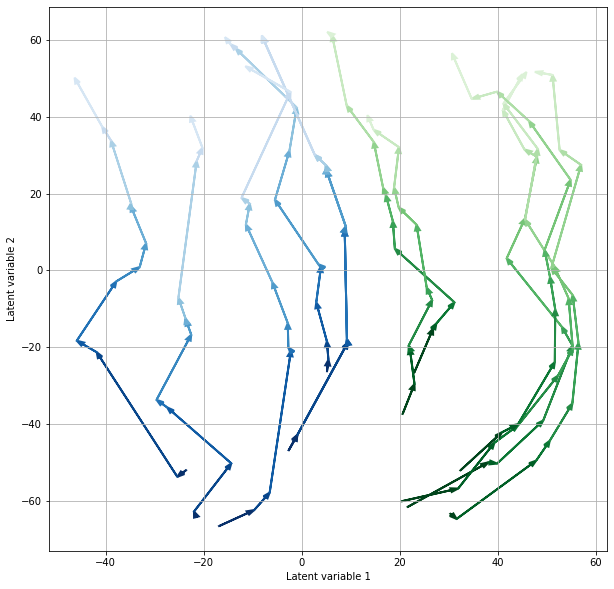

In [696]:
cmap_list=['Blues_r','Greens_r']
labels=['Digit 3','Digit 6']
plt.figure(figsize=(10, 10))
plt.grid(True)
ids=0
for i in randoms:
    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=0, vmax=12)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=plt.get_cmap(cmap_list[ids]))
    for j in range(11):        
        colorVal = scalarMap.to_rgba(j)
        plt.arrow(X_tsne[i*12+j][1], X_tsne[i*12+j][0], X_tsne[i*12+j+1,1]-X_tsne[i*12+j,1], X_tsne[i*12+j+1,0]-X_tsne[i*12+j,0], 
                  length_includes_head=True, head_width=1, lw=2,
                  color=colorVal)
    if i==digit3_randoms[-1]:
        ids+=1
plt.xlabel('Latent variable 1')
plt.ylabel('Latent variable 2')

#plt.savefig('2digit_motion_2d.jpg')

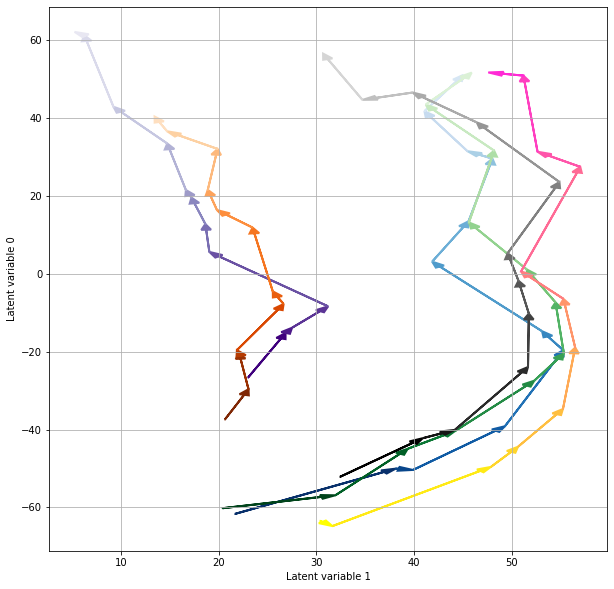

In [697]:
cmap_list=['Blues_r','Purples_r','Greens_r','Oranges_r','spring_r','gray']
plt.figure(figsize=(10, 10))
plt.grid(True)

for i in range(6):
    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=0, vmax=12)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=plt.get_cmap(cmap_list[i]))
    for j in range(11):        
        colorVal = scalarMap.to_rgba(j)
        plt.arrow(X_tsne[digit6_randoms[i]*12+j][1], X_tsne[digit6_randoms[i]*12+j][0],
                  X_tsne[digit6_randoms[i]*12+j+1,1]-X_tsne[digit6_randoms[i]*12+j,1],
                  X_tsne[digit6_randoms[i]*12+j+1,0]-X_tsne[digit6_randoms[i]*12+j,0],
                length_includes_head=True, head_width=1, lw=2, color=colorVal)
plt.xlabel('Latent variable 1')
plt.ylabel('Latent variable 0')
#plt.savefig('digit6_motion_2d.jpg')